In [1]:
import numpy as np
import pandas as pd
import scipy.stats

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('./data/combinedData.csv').drop(columns = ['Unnamed: 0'])
target = pd.read_csv('./data/combinedTarget.csv').drop(columns = ['Unnamed: 0'])

/usr/local/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (10,13,14,24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [16]:
X_train = data[data.Set == 'Train'].drop(columns='Set')
X_test = data[data.Set == 'Test'].drop(columns='Set')
y_train = target[target.Set == 'Train'].drop(columns='Set')
#y_test = target[target.Set == 'Test'].drop(columns='Set')

## Tensorflow Logistic Model

In [10]:
## If you are running tensorflow 2.0
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import time

Instructions for updating:
non-resource variables are not supported in the long term


In [22]:
print(y_train['PotentialFraud'].value_counts())
print(506/(4904))

No     4904
Yes     506
Name: PotentialFraud, dtype: int64
0.10318107667210441


Class Imbalance of 10:1

## First lets do a simple sklearn model

In [23]:
from sklearn import linear_model

In [24]:
logit1 = linear_model.LogisticRegression()

In [25]:
X_train.head()

BeneID    ClaimID ClaimStartDt  ClaimEndDt  Provider  \
0  BENE11001   CLM46614   2009-04-12  2009-04-18  PRV55912   
1  BENE11001   CLM66048   2009-08-31  2009-09-02  PRV55907   
2  BENE11001   CLM68358   2009-09-17  2009-09-20  PRV56046   
3  BENE11011   CLM38412   2009-02-14  2009-02-22  PRV52405   
4  BENE11011  CLM144521   2009-01-18  2009-01-18  PRV52314   

   InscClaimAmtReimbursed AttendingPhysician OperatingPhysician  \
0                   26000          PHY390922                NaN   
1                    5000          PHY318495          PHY318495   
2                    5000          PHY372395                NaN   
3                    5000          PHY369659          PHY392961   
4                      50          PHY379398                NaN   

  OtherPhysician AdmissionDt  ... IPAnnualDeductibleAmt  \
0            NaN  2009-04-12  ...                  3204   
1            NaN  2009-08-31  ...                  3204   
2      PHY324689  2009-09-17  ...                  3204   
3      PHY349768  2009-02-14  ...                  1068   
4            NaN         NaN  ...                  1068   

   OPAnnualReimbursementAmt OPAnnualDeductibleAmt WhetherDead NumChronics  \
0                        60                    70           0           7   
1                        60                    70           0           7   
2                        60                    70           0           7   
3                       250                   320           0           6   
4                       250                   320           0           6   

  NumProc NumDiag AdmissionDays ClaimDays   Age  
0       0      10           7.0         7  66.0  
1       1       4           3.0         3  67.0  
2       0       7           4.0         4  67.0  
3       1      10           9.0         9  95.0  
4       0       6           NaN         1  95.0  

[5 rows x 62 columns]

In [64]:
data_log = data.groupby(['Provider','Set']).agg({
    'AttendingPhysician': 'count',
    'OperatingPhysician': 'count',
    'OtherPhysician': 'count',
    'BeneID': 'count',
    'NumDiag': 'mean',
    'NumProc': 'mean',
    'NumChronics': 'mean',
    'AdmissionDays': 'mean',
}).reset_index().fillna(0)

In [79]:
X_train = data_log[data_log.Set == 'Train'].drop(columns='Set')
y_train = target[target.Set == 'Train'].drop(columns='Set')

In [73]:
X = X_train.sort_values('Provider').drop(columns = 'Provider')
y = y_train.sort_values('Provider').drop(columns = 'Provider')
y = (y == 'Yes')+0

In [91]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale

import warnings
warnings.filterwarnings(action="ignore", module="sklearn", message="^n_iter")
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss

In [92]:
X_scaled = scale(X)

In [101]:
logit1.set_params(C=1e4)
logit1.fit(X_scaled,y)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


LogisticRegression()

In [103]:
print([logit1.coef_, logit1.intercept_])

[array([[-1.09212445,  4.05139903, -0.47819443, -1.09362313,  0.22252613,
         0.0122959 ,  0.08916748,  0.71812879]]), array([-3.15746323])]


In [105]:
pred_y = logit1.predict(X_scaled)

In [107]:
probs_y = logit1.predict_proba(X_scaled)

In [111]:
import sklearn
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y, probs_y[:,1]) 

pr_auc = sklearn.metrics.auc(recall, precision)

Look for optimum threshold for prediction of fraud for our limited model

(0, 1)

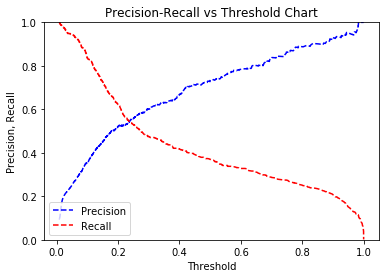

In [112]:
plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

In [119]:
prob_y >

array([0.00878133, 0.00880153, 0.00881024, ..., 0.99999999, 1.        ,
       1.        ])

In [125]:
(abs(precision - recall) < 1e-6)+0


array([0, 0, 0, ..., 0, 0, 0])

In [113]:
sgd = SGDClassifier(loss='log', shuffle=False)
sgd

SGDClassifier(loss='log', shuffle=False)

In [100]:
warm_start = False
sgd = SGDClassifier(loss='log')
sgd.set_params(learning_rate='constant', eta0=0.1)
sgd_steps = range(1,4502,15) 
losses_sgd = []
scores_sgd = []
previous_step = 0
usePrevious_step = True
for step in sgd_steps:
        sgd.set_params(warm_start=warm_start, 
                       n_iter= step - previous_step,shuffle=True, verbose=False)
        sgd.fit(X_scaled,y)
        scores_sgd.append(sgd.score(X_scaled,y))
        losses_sgd.append(log_loss(y, sgd.predict_proba(X_scaled)))
        warm_start = True  # set warm_start to True after the intial iteration
        if usePrevious_step: previous_step = step
sgd.score(X_scaled, y) 

ValueError: Invalid parameter n_iter for estimator SGDClassifier(eta0=0.1, learning_rate='constant', loss='log'). Check the list of available parameters with `estimator.get_params().keys()`.

In [160]:
data = data.merge(target, on=['Provider','Set'], how='inner')

In [161]:
singletons = (data.groupby('Provider')['BeneID'].count() == 1)

In [162]:
one_bene = singletons.index[singletons].values

In [163]:
one_data = data[data.Provider.isin(one_bene)]


In [167]:
hue_feature = 'PotentialFraud'

<Figure size 432x576 with 0 Axes>

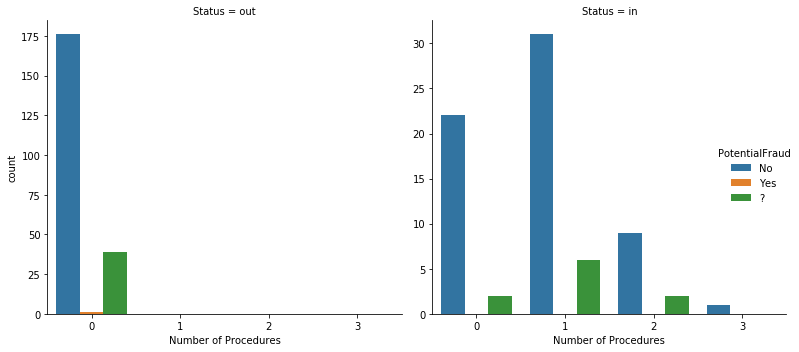

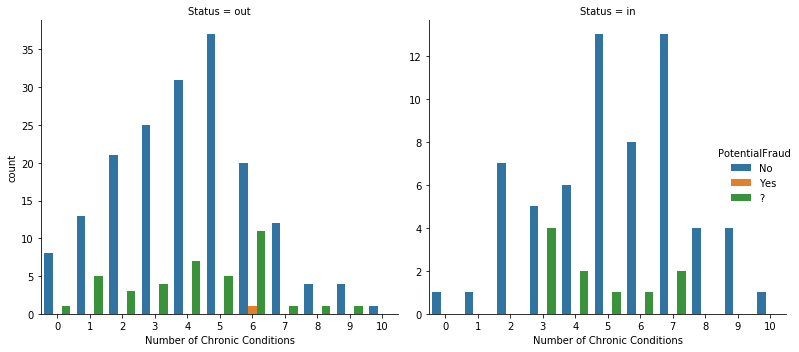

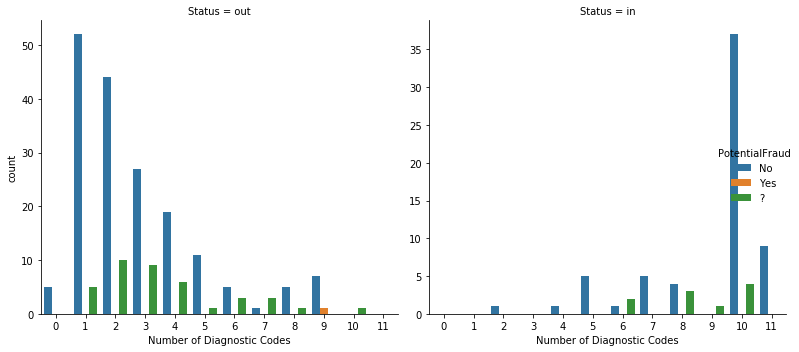

In [182]:
plt.figure(figsize=(6,8))

ax1 = sns.catplot(x='NumProc', 
                    hue = hue_feature, 
                  col='Status',
                  kind='count',
                  sharey=False,
                    data=one_data)

ax1.set(xlabel='Number of Procedures')
plt.tight_layout()

#ax1.figure.savefig("./visualizations/aiko/age_Claims.png",bbox_inches='tight')


ax2 = sns.catplot(x='NumChronics', 
                    hue = hue_feature, 
                  col='Status',
                  kind='count',
                  sharey=False,
                    data=one_data)

ax2.set(xlabel='Number of Chronic Conditions')
plt.tight_layout()



#plt.subplot((313))
ax3 = sns.catplot(x='NumDiag', 
                  hue = hue_feature, 
                  col='Status',
                  kind='count',
                  sharey=False,
                  data=one_data)

ax3.set(xlabel='Number of Diagnostic Codes')
plt.tight_layout()